# FA7 - AES 128 DFA on real target

With this exercise, you will practice fault injection on a real target doing AES 128 encryption.

# Challenge

Retrieve the AES key used to encrypt the data

### Characterization

To characterize the best parameters, you will have to glitch a simple function which counts up to 2500. If the right parameters are set, the device should reply with a value different than that.

### Attack

To attack this implementation, you have several options :

 - Attacks on the 8th round of AES
 - Attacks on the 9th round of AES (See the slides about fault propagation to see the patterns)
 - Attacks on the 10th round, before the SBox operation
 - Attacks on the 10th round, during the last AddRoundKey

Some of the attacks are implemented in the [phoenixAES](https://github.com/SideChannelMarvels/JeanGrey) library

In [4]:
#Imports

import chipwhisperer as cw
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import glob
import seaborn as sns
import phoenixAES

In [5]:
# Chipwhisperer basic configuration

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial2)
prog = cw.programmers.STM32FProgrammer
scope.default_setup()

#Chipwhisperer clock is fed to the target chip
scope.clock.clkgen_freq = 24E6
target.baud = 230400*24/7.37

cw.set_all_log_levels(cw.logging.CRITICAL)

# Already decimate the ADC samples. This way, ext_offset matches the ADC samples
scope.adc.samples = 8000
scope.adc.decimate = 4

In [6]:
#Helper functions

def target_reset():
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)
    target.flush()


In [7]:
#Test that everything goes well by sending the loop command and check its output

target_reset()
scope.arm()
target.simpleserial_write("g", bytearray([]))
scope.capture()
val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)
# Should print
# {'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}

{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}


In [8]:
#Encrypt a plaintext and retrieve the ciphertext
# This can be used as your reference ciphertext for further attacks

target_reset()
scope.arm()
target.simpleserial_write("p", b'0123456789abcdef')
scope.capture()
val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    print(response)
    CLEAN_CIPHERTEXT = response


CWbytearray(b'cd 8f e4 fa ee 3e b0 ce bf 2d 4f eb 3d fa 2e cb')


In [13]:
# print password and response as a hex string
password = "0123456789abcdef"
password = password.encode("utf-8").hex()
print(password)
print("".join("{:02x}".format(x) for x in response))

30313233343536373839616263646566
cd8fe4faee3eb0cebf2d4feb3dfa2ecb


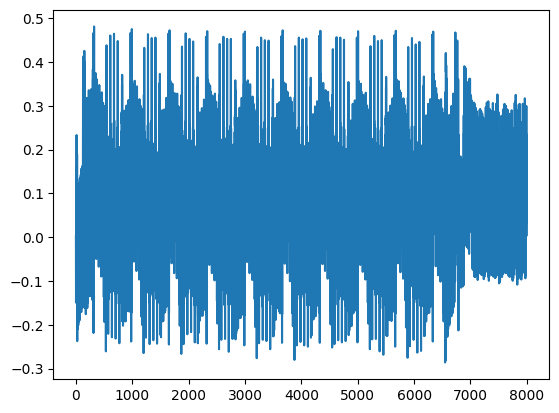

In [9]:
# For the last encryption, show the associated power trace
plt.plot(scope.get_last_trace())

In [15]:
#Basic glitch settings

scope.glitch.clk_src = "clkgen" # glitch counters use the main clock (24MHz)
scope.glitch.output = "glitch_only" # Glitch output signal
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
scope.io.glitch_lp = True # Enable low power MOSFET
scope.io.glitch_hp = True # Enable high power MOSFET
scope.glitch.repeat = 7 # Number of successive glitches, 7 should be OK for our target

In [ ]:
# Characterization loop

# Thic block will iterate over some of the glitch parameters to locate the "sweet spot"
# where the glitches produce an effect

# Change this block accordingly in order to find the parameters that produce
# the maximum amount of glitches before going further the template

# ext_offset is the number of clock cycles after the trigger

def characterize_chip(offset_min: float, offset_max: float, offset_step: float, width_min: float, width_max: float, width_step: float, save_to_file: bool = False, show_progress: bool = True):
  df = pd.DataFrame(columns=['offset','width', 'count'])

  offsets = np.arange(offset_min, offset_max, offset_step)
  widths = np.arange(width_min, width_max, width_step)

  for ext_offset in range(1,2):
      scope.glitch.ext_offset = ext_offset
      
      # offset is the percentage into the clock cycle where the glitch starts
     
      progress_offsets = tqdm(offsets, desc="Offset", position=0, disable=not show_progress)

      for offset in progress_offsets:
        scope.glitch.offset = offset
          # progress_offsets.set_description(f"Offset {offset:0.2f}")
          

          # Width is the percentage of the period to glitch
          
        progress_widths = tqdm(widths, desc="Width", position=1, leave=False, disable=not show_progress)
        for width in progress_widths:
            scope.glitch.width = width
            # progress_widths.set_description(f"Width {width:0.2f}")
            
            # Repeat each iteration 5 times to ensure we get consistant results
            count = 0
            for _ in range(5):
                
                #Fun starts here
                target_reset()
                scope.arm()
                target.simpleserial_write("g", bytearray([]))
                ret = scope.capture()
                #scope.io.vglitch_reset()
                
                # read response from target
                val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10, timeout=30)
                
                # If no response from the chip, assume it crashed
                if val['valid'] is False:
                    # print("X", end="")
                    continue
                
                # if counter is different thant the correct value, print the results
                counter = int.from_bytes(val['payload'], byteorder='little')
                if counter != 2500:
                    count += 1
                    # print(f"*{counter:08d}*", end="")
                    
                # else:
                    # print(".", end="")
            if count > 0:
                # print()
                # print(f"Count {count:02d}\text_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}")
                df.loc[len(df.index)] = [offset, width, count]
        if save_to_file and not df.empty:
          df.to_csv(f"data/offset_{offset}.csv")
          df = pd.DataFrame(columns=['offset','width', 'count'])
  return df

In [ ]:
df = characterize_chip(-23.8, -19.3, 0.2, 35.3, 35.8, 0.1, save_to_file=True, show_progress=True)

In [ ]:
# Load result file
res_files = glob.iglob("data/[!merged]*.csv")
merged_data = pd.DataFrame(columns=['offset','width', 'count'])
merged_data = pd.concat(map(pd.read_csv, res_files), ignore_index= True).drop(columns=['Unnamed: 0'])
merged_data = merged_data.round(2)
merged_data.to_csv("data/merged.csv")
print(merged_data)

In [ ]:
sns.heatmap(merged_data.pivot(index="offset", columns="width", values="count"), annot=False, fmt="g", cmap="YlGnBu")

In [16]:
# ext_offset is the number of clock cycles after the trigger
for ext_offset in range(5700,6500): #set ext_offset to reach the desired round
    scope.glitch.ext_offset = ext_offset
    
    # offset is the percentage into the clock cycle where the glitch starts
    for offset in np.arange(-23.8, -19.3, 0.2): 
        scope.glitch.offset = offset
        
        # Width is the percentage of the period to glitch
        for width in  np.arange(35.3, 35.9, 0.1):
            scope.glitch.width = width

            for _ in range(5):

                #Fun starts here

                target_reset()
                scope.arm()
                # Send dummy password
                target.simpleserial_write("p", b'0123456789abcdef')
                ret = scope.capture()

                val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10, timeout=30)
                if val['valid'] is False:
                    print("X", end="")
                    continue

                result = val['payload']
                if result != CLEAN_CIPHERTEXT:
                    xor = bytes(a ^ b for (a, b) in zip(CLEAN_CIPHERTEXT, result))
                    print()
                    print(f"ext_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}\tResult {result.hex()}\txor: {xor.hex()}")
                    try:
                        print(result.decode())
                    except:
                        pass

                else:
                    print(".", end="")


..............................
ext_offset 5700	Width 35.90	Offset -23.80	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f
...X.........................X...X..
ext_offset 5700	Width 35.90	Offset -23.60	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f

ext_offset 5700	Width 35.90	Offset -23.60	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f
X.........................X...X.XX...........................X.XX..
ext_offset 5700	Width 35.90	Offset -23.20	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f

ext_offset 5700	Width 35.90	Offset -23.20	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f

ext_offset 5700	Width 35.90	Offset -23.20	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6257de6c11f
..........................XXX.X
ext_offset 5700	Width 35.90	Offset -23.00	Result 119f9514075ab76eaf6399ce401cefd4	xor: dc1071eee96407a0104ed6

KeyboardInterrupt: 

In [17]:
with open('tracefile', 'wb') as t:
    t.write("""
30313233343536373839616263646566 cd8fe4faee3eb0cebf2d4feb3dfa2ecb
30313233343536373839616263646566 119f9514075ab76eaf6399ce401cefd4
30313233343536373839616263646566 6910fcb680f6ecc59051c1432bfa9518
30313233343536373839616263646566 119f95e8075a566eafc399ce721cefd4
""".encode('utf8'))

phoenixAES.crack_file('tracefile')

In [14]:
with open('tracefile', 'wb') as t:
    t.write("""
30313233343536373839616263646566 cd8fe4faee3eb0cebf2d4feb3dfa2ecb
30313233343536373839616263646566 119f9514075ab76eaf6399ce401cefd4
30313233343536373839616263646566 6910fcb680f6ecc59051c1432bfa9518
30313233343536373839616263646566 119f95e8075a566eafc399ce721cefd4
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
30313233343536373839616263646566 
""".encode('utf8'))

phoenixAES.crack_file('tracefile')

In [ ]:
scope.dis()